In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import xarray
import firedrake
from firedrake import inner, grad, dx, ds, max_value, sqrt, exp, Constant
import icepack
from icepack.constants import (
    ice_density as rhoI,
    water_density as rhoW,
    gravity as g,
    weertman_sliding_law as m,
)
import modelfunc as mf
from icepack.models.viscosity import viscosity_depth_averaged

### Initial setup

Read in the mesh.

In [2]:
inversionParams =     defaults = {'geometry': '/Volumes/insar11/ian/ModelRuns/icepack/PIG-Thwaites/PIGThwaitesGeometryBedMachine.yaml',
                'velocity':
                '/Volumes/insar11/ian/ModelRuns/icepack/Data/PIGThwaites/velocity/ASE_vel_mosaic_composite_01Jan19_31Dec20',
                'mesh': '/Volumes/insar11/ian/ModelRuns/icepack/PIG-Thwaites/meshes/PiGThwaites.exp',
                'meshOversample': 2,
                'rheology': '/Volumes/insar11/ian/ModelRuns/icepack/PIG-Thwaites/B/PIGThwaites2020.B.tif',
                'degree': 1,
                'friction': 'weertman',
                'maxSteps': 30,
                'rtol': 0.5e-3,
                'GLTaper': 4000,
                'solveViscosity': True,
                'solveBeta': True,
                'solverMethod': 'GaussNewton',
                'initWithDeg1': False,
                'initFile': None,
                'plotResult': False,
                'params': None,
                'inversionResult': None,
                'uThresh': 300,  # Here&down change only through params file
                'alpha': 2000,
                'regTheta': 1.,
                'regBeta': 1.
                }

In [3]:
def getFrictionLaw(modelName):
    ''' Lookup the friction model by model name (weertman or schoof) '''
    # Available models; augment as needed.
    frictionModels = {'weertman': mf.weertmanFriction,
                      'schoof': mf.schoofFriction}
    return frictionModels[modelName]


def getSolverMethod(solverMethodName):
    ''' Lookup solver method by name (GaussNewton, BFGS) '''
    # available methods; add new methods as needed.
    solverMethods = {'GaussNewton': icepack.inverse.GaussNewtonSolver,
                     'BFGS': icepack.inverse.BFGSSolver}
    return solverMethods[solverMethodName]
Print = print

def setupTaperedMasks(inversionParams, grounded, floating):
    ''' Smooth or copy floating and grounded masks for tapering near gl
    '''
    # global floatingSmooth, groundedSmooth
    if inversionParams['GLTaper'] < 1:
        floatingSmooth = floating.copy(deepcopy=True)
        groundedSmooth = grounded.copy(deepcopy=True)
    else:
        groundedSmooth = mf.firedrakeSmooth(grounded,
                                            alpha=inversionParams['GLTaper'])
        floatingSmooth = mf.firedrakeSmooth(floating,
                                            alpha=inversionParams['GLTaper'])
    return groundedSmooth, floatingSmooth

def betaInit(s, h, speed, V, Q, grounded, inversionParams):
    """Compute intitial beta using 0.5 taud.
    Parameters
    ----------
    s : firedrake function
        model surface elevation
    h : firedrake function
        model thickness
    speed : firedrake function
        modelled speed
    V : firedrake vector function space
        vector function space
    Q : firedrake function space
        scalar function space
    grounded : firedrake function
        Mask with 1s for grounded 0 for floating.
    """
    # Use a result from prior inversion
    if inversionParams['initFile'] is not None:
        # This will break on the older files
        print(inversionParams['initFile'], 'beta')
        betaTemp = mf.getCheckPointVars(inversionParams['initFile'],
                                        'betaInv', Q)['betaInv']
        beta1 = icepack.interpolate(betaTemp, Q)
        Print(f'Initialized beta with {inversionParams["initFile"]}')
        return beta1
    # No prior result, so use fraction of taud
    tauD = firedrake.project(-rhoI * g * h * grad(s), V)
    #
    stress = firedrake.sqrt(firedrake.inner(tauD, tauD))
    Print('stress', firedrake.assemble(stress * firedrake.dx))
    fraction = firedrake.Constant(0.999)
    U = max_value(speed, 1)
    C = fraction * stress / U**(1/m)
    if inversionParams['friction'] == 'schoof':
        print('schoof')
        mExp = 1/m + 1
        U0 = firedrake.Constant(inversionParams['uThresh'])
        C = C * (m/(m+1)) * (U0**mExp + U**mExp)**(1/(m+1))
    beta = icepack.interpolate(firedrake.sqrt(C) * grounded, Q)
    return beta


def thetaInit(Ainit, Q, grounded, floating, inversionParams):
    """Compute intitial theta on the ice shelf (not grounded).
    Parameters
    ----------
    Ainit : firedrake function
        A Glens flow law A
    Q : firedrake function space
        scalar function space
    Q1 : firedrake function space
        1 deg scalar function space used with 'initWithDeg1'
    grounded : firedrake function
        Mask with 1s for grounded 0 for floating.
    floating : firedrake function
        Mask with 1s for floating 0 for grounded.
    Returns
    -------
    theta : firedrake function
        theta for floating ice
    """
    # Now check if there is a file specificed, and if so, init with that
    if inversionParams['initFile'] is not None:
        Print(f'Init. with theta: {inversionParams["initFile"]}')
        # This will break on the older files
        thetaTemp = mf.getCheckPointVars(inversionParams['initFile'],
                                         'thetaInv', Q)['thetaInv']
        thetaInit = icepack.interpolate(thetaTemp, Q)
        return thetaInit
    # No initial theta, so use initial A to init inversion
    Atheta = mf.firedrakeSmooth(Ainit, alpha=1000)
    theta = firedrake.ln(Atheta)
    theta = icepack.interpolate(theta, Q)
    return theta

def printExtremes(**kwargs):
    ''' Print min/max of firedrake functions to flag bad inputs'''
    Print('Min/Max of input values')
    Print(''.join(['-']*40))
    for arg in kwargs:
        Print(arg, kwargs[arg].dat.data_ro.min(),
              kwargs[arg].dat.data_ro.max())
    Print(''.join(['-']*40))

def taperedViscosity(velocity, thickness, fluidity, theta,
                     groundedSmooth, floatingSmooth):
    ''' This is a test version to use feathered grouning to floating transition
    '''
    # Combine tapered A on grouned and theta for smooth
    A = groundedSmooth * fluidity + floatingSmooth * firedrake.exp(theta)
    viscosity = \
        icepack.models.viscosity.viscosity_depth_averaged(velocity=velocity,
                                                          thickness=thickness,
                                                          fluidity=A)
    return viscosity

In [4]:
frictionLaw = getFrictionLaw(inversionParams['friction'])
#solverMethod = getSolverMethod(inversionParams['solverMethod'])

In [5]:
meshI = None
mesh, Q, V, meshOpts = \
mf.setupMesh(inversionParams['mesh'],
            degree=inversionParams['degree'],
            meshOversample=inversionParams['meshOversample'],
            newMesh=meshI)
Print(f'Mesh Elements={mesh.num_cells()} Vertices={mesh.num_vertices()}')

Header info 35434 70013 5 3
parseNodes
35434 35434 70013 70013
segments
Mesh Elements=280052 Vertices=140883


In [6]:

area = firedrake.assemble(firedrake.Constant(1) * firedrake.dx(mesh))
opts = {'dirichlet_ids': meshOpts['dirichlet_ids']}  # Opts from mesh
#
# Input model geometry and velocity
zb, s, h, floating, grounded = \
    mf.getModelGeometry(inversionParams['geometry'], Q, smooth=True,
                        alpha=inversionParams['alpha'])
#
# Smooth versions of masks for tapered function
groundedSmooth, floatingSmooth = setupTaperedMasks(inversionParams,
                                                   grounded, floating)
# Get speed
uObs, speed, sigmaX, sigmaY = \
    mf.getModelVelocity(inversionParams['velocity'], Q, V,
                        minSigma=5, maxSigma=100)
# Get initial guess for rheology
A = mf.getRateFactor(inversionParams['rheology'], Q)

bed /Volumes/insar11/ian/ModelRuns/icepack/Data/PIGThwaites/bedMachineDerived/PIGThwaites.Bed.BM.tif
floatMask /Volumes/insar11/ian/ModelRuns/icepack/Data/PIGThwaites/bedMachineDerived/PIGThwaites.flotation.MB.tif
surface /Volumes/insar11/ian/ModelRuns/icepack/Data/PIGThwaites/bedMachineDerived/PIGThwaites.Surface.BM.tif
thickness /Volumes/insar11/ian/ModelRuns/icepack/Data/PIGThwaites/bedMachineDerived/PIGThwaites.Thickness.BM.tif
bed min/max   -2250.74    1868.51
floatMask min/max       0.00       1.00
surface min/max      22.80    2552.06
thickness min/max     157.66    3966.49


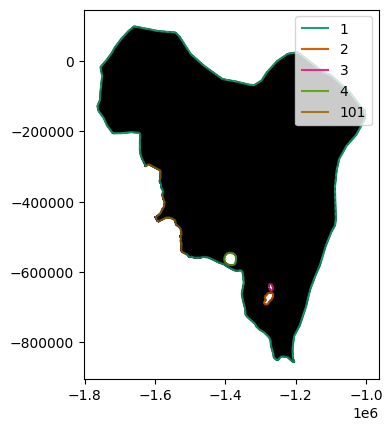

In [7]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, axes=ax)
ax.legend(loc="upper right");

In [8]:
beta0 = betaInit(s, h, speed, V, Q, grounded, inversionParams)
theta = thetaInit(A, Q, grounded, floating, inversionParams)

stress 26913551759.951523


## Ln Method

In [13]:
ρ_I = rhoI
ρ_W = rhoW
δh = firedrake.Function(Q).interpolate(s - (1 - ρ_I / ρ_W) * h)
δh_c = firedrake.Constant(50.0)
f_interior = firedrake.Constant(0.95)
f = firedrake.conditional(
    δh >= δh_c,
    f_interior,
    0.05,
)

In [14]:

α = firedrake.Constant(10e3)
τ_obs = -ρ_I * g * h * grad(s)
τ_d = firedrake.Function(V)
J = 0.5 * (inner(τ_d - τ_obs, τ_d - τ_obs) + α**2 * inner(grad(τ_d), grad(τ_d))) * dx
F = firedrake.derivative(J, τ_d)
firedrake.solve(F == 0, τ_d)

In [16]:
τ_initial = f * sqrt(inner(τ_d, τ_d))
u_min = firedrake.Constant(10.0)
U = max_value(u_min, sqrt(inner(uObs, uObs)))
expr = τ_initial / U ** (1 / m)
C_0 = firedrake.Function(Q).interpolate(expr)

In [19]:
u_0 = Constant(25.0)
def friction(**kwargs):
    u, ϕ = map(kwargs.get, ("velocity", "log_friction"))
    return m / (m + 1) * C_0 * exp(ϕ) * sqrt(inner(u, u) + u_0**2) ** (1 / m + 1)
    
# Print min/max for quick QA of inputs
printExtremes(h=h, s=s, A=A, beta=beta0, theta=theta)
# Assign uThresh here to force correct type for parameter
uThresh = firedrake.Constant(inversionParams['uThresh'])
#
# Setup diagnostic solve and solve for inital model velocity
model = icepack.models.IceStream(friction=friction,
                                 viscosity=taperedViscosity)
solver = icepack.solvers.FlowSolver(model, **opts)
print(opts)
ϕ = firedrake.Function(Q)
# Initial solve
u = solver.diagnostic_solve(velocity=uObs, thickness=h, surface=s,
                            fluidity=A,
                           log_friction=ϕ, theta=theta, grounded=grounded,
                            groundedSmooth=groundedSmooth,
                            floatingSmooth=floatingSmooth,
                            uThresh=uThresh,
                            floating=floating)

Min/Max of input values
----------------------------------------
h 157.65897823699748 3966.4925727623354
s 22.797873166894533 2552.0598094948823
A 1.5287305244783098 56.5080681906273
beta 0.0 0.4541932556657624
theta 0.4947317000638316 4.020642817717528
----------------------------------------
{'dirichlet_ids': [1, 2, 3, 4]}


In [37]:
area = firedrake.assemble(Constant(1.0) * dx(mesh))
Ω = Constant(area)
area1 = firedrake.assemble(Constant(1.0) * dx(mesh))
mf.velocityError(uObs, u, area1, message='Initial error')

Initial error v error     238.42 (m/yr)


238.42095485804734

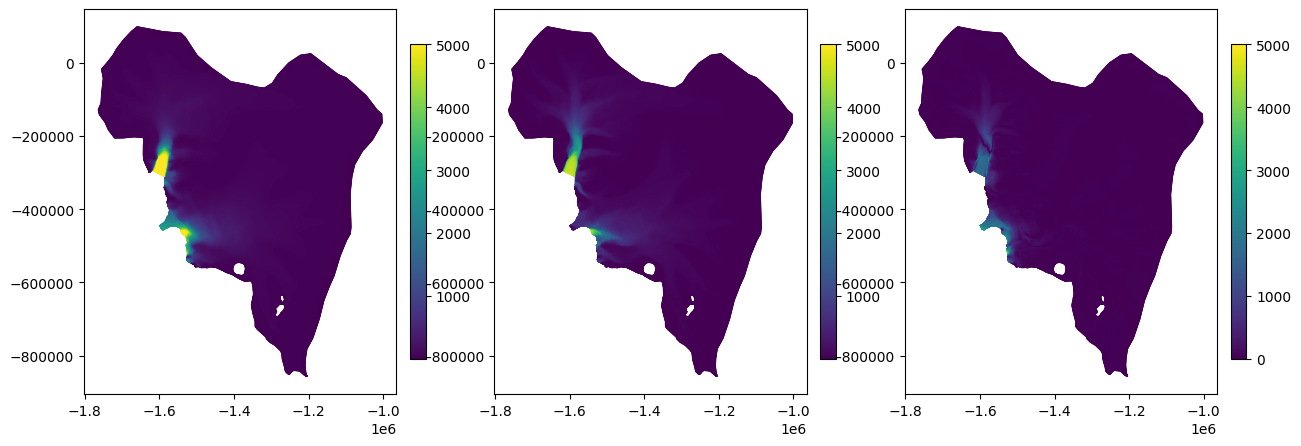

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, x in zip(axes.flatten(),[u, uObs, icepack.interpolate(u-uObs, V)]):
    colors0 = firedrake.tripcolor(x, axes=ax, vmax=5000)
    fig.colorbar(colors0, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)


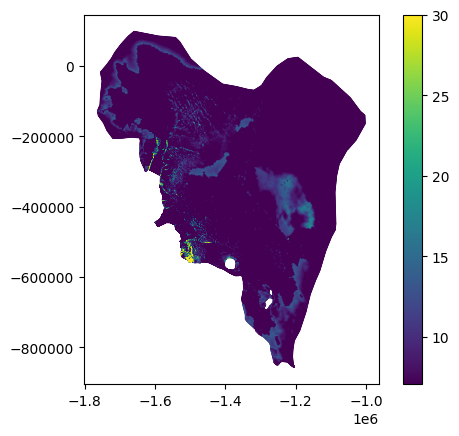

In [22]:
sigma = firedrake.Function(Q).interpolate(sqrt(sigmaX**2 + sigmaY**2))
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(sigma, vmax=30.0, axes=ax)
fig.colorbar(colors);

In [38]:
def makeRegularizationBeta(grounded, regBeta):
    ''' Allows passing additional variables to rebularizationBeta '''
    def regularizationBeta(beta):
        """Regularization function for beta in friction inversion
        Parameters
        ----------
        beta : firedrake function
            Beta for friction model with C=beta^2
        Returns
        -------
        R: Firedrake function
            Regularization with dx
        """
        Phi = firedrake.Constant(3.)
        L = firedrake.Constant(np.sqrt(1000.) * 19.5e3)
        R =  firedrake.Constant(0.5) * regBeta * grounded * (L / Phi)**2 * \
            firedrake.inner(grad(beta), grad(beta)) * firedrake.dx
        return R
    return regularizationBeta
#
regularizationBeta =  makeRegularizationBeta(grounded, firedrake.Constant(1e-6))

In [44]:
σx = sigmaX
σy = sigmaY
def loss_functional(u):
    δu = u - uObs
    return 0.5 / Ω * ((δu[0] / σx)**2 + (δu[1] / σy)**2) * dx

α = Constant(5e3)
def friction_regularization(ϕ):
    return 0.5 / Ω * α**2 * inner(grad(ϕ), grad(ϕ)) * dx

In [45]:
def makeFriction_simulation(uObs, h, s, A, theta, grounded, groundedSmooth, floating, floatingSmooth, uThresh):
    def friction_simulation(ϕ):
        return solver.diagnostic_solve(velocity=uObs, thickness=h, surface=s,
                                        fluidity=A,
                                        theta=theta,
                                        log_friction=ϕ, grounded=grounded,
                                        groundedSmooth=groundedSmooth,
                                        floatingSmooth=floatingSmooth,
                                        uThresh=uThresh,
                                        floating=floating)
    return friction_simulation
friction_simulation = makeFriction_simulation(uObs, h, s, A, theta, grounded, groundedSmooth, floating, floatingSmooth, uThresh)

In [52]:
def friction_simulation(ϕ):
    return solver.diagnostic_solve(velocity=uObs, thickness=h, surface=s,
                                    fluidity=A,
                                    theta=theta,
                                    log_friction=ϕ, grounded=grounded,
                                    groundedSmooth=groundedSmooth,
                                    floatingSmooth=floatingSmooth,
                                    uThresh=uThresh,
                                    floating=floating)

In [53]:
area = Constant(firedrake.assemble(Constant(1.0) * dx(mesh)))
def makeLossFunctional(uObs, area, sigmaX, sigmaY):
    def loss_functional(u):
        du = u - uObs
        return firedrake.Constant(0.5) / area * ((du[0] / sigmaX)**2 + (du[1] / sigmaY)**2) * dx
    return loss_functional
#loss_functional = makeLossFunctional(uObs, area, sigmaX, sigmaY)

In [54]:
beta = firedrake.Function(Q)
values = beta.dat.data
values[:] = beta0.dat.data
from icepack.statistics import (
    StatisticsProblem,
    MaximumProbabilityEstimator,
)

friction_problem = StatisticsProblem(
    simulation=friction_simulation,
    loss_functional=loss_functional,
    regularization=friction_regularization,
    controls=ϕ
)

In [57]:
help(friction_estimator)

Help on MaximumProbabilityEstimator in module icepack.statistics object:

class MaximumProbabilityEstimator(builtins.object)
 |  MaximumProbabilityEstimator(problem, solver_type='rol', **kwargs)
 |
 |  Methods defined here:
 |
 |  __init__(self, problem, solver_type='rol', **kwargs)
 |      Estimates the true value of the controls by computing the maximizer
 |      of the posterior probability distribution
 |
 |  solve(self)
 |
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |
 |  controls
 |
 |  problem
 |
 |  state
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [56]:
friction_estimator = MaximumProbabilityEstimator(
    friction_problem,
    gradient_tolerance=1e-2,
    step_tolerance=1e+1,
    max_iterations=50,
)
beta_opt = friction_estimator.solve()

ValueError: Firedrake Constant requires a domain to work with pyadjoint

In [ ]:
u = solver.diagnostic_solve(velocity=uObs, thickness=h, surface=s,
                            fluidity=A,
                            beta=beta, theta=theta, grounded=grounded,
                            groundedSmooth=groundedSmooth,
                            floatingSmooth=floatingSmooth,
                            uThresh=uThresh,
                            floating=floating)

In [ ]:
mf.velocityError(uObs, u, area1, message='Initial error')

In [ ]:
u1 = friction_simulation(beta)

In [ ]:
mf.velocityError(u1, u, area1, message='Initial error')

In [ ]:
firedrake.assemble(loss_functional(u))

In [ ]:
firedrake.assemble(regularizationBeta(beta))

In [ ]:
beta

Read in the velocity data.

In [ ]:
beta = firedrake.Function(Q)
beta

In [ ]:
measures_filename = icepack.datasets.fetch_measures_antarctica()
measures = xarray.open_dataset(measures_filename)

In [ ]:
np.sum(np.isnan(measures["VX"])).data[

In [ ]:
u_obs = icepack.interpolate((measures["VX"], measures["VY"]), V)
print(np.sum(np.isnan(u_obs.dat.data_ro)))
speed = firedrake.sqrt(firedrake.inner(u_obs, u_obs))

There are some missing points, so just mask them out with 0.
**TODO**: Fix this awfulness.

In [ ]:
u_obs.dat.data[np.isnan(u_obs.dat.data_ro)] = 0
print(np.sum(np.isnan(u_obs.dat.data_ro)))

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(u_obs, axes=ax)
fig.colorbar(colors);

Read in the bed, thickness, and surface elevation data.

In [ ]:
bedmachine_filename = icepack.datasets.fetch_bedmachine_antarctica()
bedmachine = xarray.open_dataset(bedmachine_filename)

In [ ]:
b = icepack.interpolate(bedmachine["bed"], Q)
h_obs = icepack.interpolate(bedmachine["thickness"], Q)
h_min = firedrake.Constant(10.0)
h = firedrake.Function(Q).interpolate(max_value(h_min, h_obs))

In [ ]:
zF = modelfunc.flotationHeight(b, Q)
floating, grounded = modelfunc.flotationMask(s, zF, Q)
fig, axes= plt.subplots(1, 3, figsize=(12, 5))
for ax, x in zip(axes.flatten(), [icepack.interpolate(s-zF, Q), floating, grounded]):
    ax.set_aspect("equal")
    colors = firedrake.tripcolor(x, axes=ax)
    #ax.colorbar(colors);

## Surface Temp

In [ ]:
!wget --no-clobber https://store.pangaea.de/Publications/LeBrocq_et_al_2010/ALBMAPv1.nc.zip
!unzip -n ALBMAPv1.nc.zip

In [ ]:
albmap = xarray.open_dataset("ALBMAPv1.nc").rename({"x1": "x", "y1": "y"})
[var for var in albmap.data_vars]

In [ ]:
T_surface = icepack.interpolate(albmap["temp"], Q)
a = icepack.interpolate(albmap["acca"], Q)

## Initial $\beta$

In [ ]:
tauD = firedrake.project(-rhoI * g * h * grad(s), V)
uThresh = firedrake.Constant(300)
#
stress = firedrake.sqrt(firedrake.inner(tauD, tauD))
print('stress', firedrake.assemble(stress * firedrake.dx))
fraction = firedrake.Constant(0.95)
U = max_value(speed, 1)
C = fraction * stress / U**(1/m)
mExp = 1/m + 1
U0 = firedrake.Constant(uThresh)
C = C * (m/(m+1)) * (U0**mExp + U**mExp)**(1/(m+1))
beta = icepack.interpolate(firedrake.sqrt(C) * grounded, Q)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for ax, x in zip(axes.flatten(), [tauD, beta]):
    ax.set_aspect("equal")
    colors = firedrake.tripcolor(x, axes=ax)

## Friction Function

In [ ]:
friction = modelfunc.schoofFriction

## Initial Fluidity

In [ ]:
T = firedrake.Function(Q).interpolate(T_surface + 273.15)
A_0 = icepack.interpolate(icepack.rate_factor(T), Q)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for ax, x in zip(axes.flatten(), [T, A_0]):
    ax.set_aspect("equal")
    colors = firedrake.tripcolor(x, axes=ax)

## Viscosity Function

In [ ]:
def viscosity(velocity, thickness, fluidity):
    print('here', np.max(thickness.dat.data_ro), np.max(fluidity.dat.data_ro))
    #A = A_0 * exp(log_fluidity)
    return viscosity_depth_averaged(velocity=velocity, thickness=thickness, fluidity=fluidity)


## Model

In [ ]:
model = icepack.models.IceStream(friction=friction, viscosity=viscosity)
opts = {
    "dirichlet_ids": [1]}
#    "diagnostic_solver_type": "petsc",
#    "diagnostic_solver_parameters": {
#        #"snes_monitor": None,
#        "snes_type": "newtonls",
#        "snes_linesearch_type": "cp",
#        "ksp_type": "gmres",
#        "pc_type": "lu",
#        "pc_factor_mat_solver_type": "mumps",
#    },
#}
solver = icepack.solvers.FlowSolver(model, **opts)




In [ ]:
u = solver.diagnostic_solve(velocity=u_obs, thickness=h, surface=s,
                            fluidity=A_0,
                            beta=beta, grounded=grounded,
                            uThresh=uThresh)

In [ ]:
type(uThresh)